In [1]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import random

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

import plotly.graph_objs as go
import plotly.express as px 

from kernel_sca_inducing_points import *

In [38]:

def DDM(mu, sigma, dt, total_time, key, trials):
    num_trajectories = len(mu)
    num_steps = int(total_time / dt)
    x = jnp.zeros((num_trajectories, num_steps + 1))
    ls_RT = []
    ls_acc = []

    keys = random.split(key, num_trajectories)

    for i in range(num_trajectories):
        current_key = keys[i]
        for t in range(num_steps):
            if jnp.abs(x[i, t]) < 1:
                normal_sample = random.normal(current_key, shape=())
                x = x.at[i, t + 1].set(x[i, t] + mu[i] * dt + sigma * jnp.sqrt(dt) * normal_sample)
                current_key, subkey = random.split(current_key)
            else:
                ls_RT.append(t)
                ls_acc.append(1 if jnp.sign(x[i, t]) == jnp.sign(mu[i]) else -1)
                
                x = x.at[i, t:].set(jnp.sign(x[i, t]))
                break
    return x, ls_RT, ls_acc

mu = np.array([-0.64, -0.32, -0.16, -0.08, -0.04, 0.0, 0.04, 0.08, 0.16, 0.32, 0.64])  
sigma = 0.35
dt = 0.1
total_time = 100 
trials = 150

ls_RTs = []
ls_accs = []
paths = jnp.zeros((trials, len(mu), int(total_time / dt) + 1))
for i in range(trials):
    key = random.PRNGKey(42 + i)
    path, ls_RT, ls_acc = DDM(mu, sigma, dt, total_time, key, trials) 
    paths = paths.at[i].set(path)
    ls_RTs.append(ls_RT)
    ls_accs.append(ls_acc)

accs = jnp.array(ls_accs)
RTs = jnp.array(ls_RTs)
paths = paths[:,:, :jnp.max(RTs)]

# single_trial = False
# if single_trial:
#     paths_run = paths.reshape(-1, jnp.max(RTs))
# else:
#     paths_run = jnp.mean(paths, axis=0)#[jnp.newaxis,:,:]

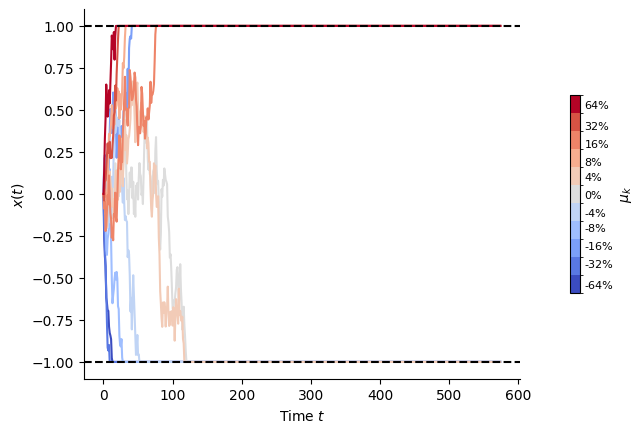

In [39]:

fig, ax = plt.subplots()
#times = np.linspace(0, total_time, int(total_time / dt) + 1)

boundaries = np.concatenate(([mu[0] - (mu[1] - mu[0])/2], (mu[:-1] + mu[1:])/2, [mu[-1] + (mu[-1] - mu[-2])/2]))
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(mu))
cmap = plt.get_cmap('coolwarm', len(mu))

for i, m in enumerate(mu):
    ax.plot(paths[3, i, :], color=cmap(norm(m)))

ax.axhline(y=1, color='black', linestyle='--')
ax.axhline(y=-1, color='black', linestyle='--')
ax.set_xlabel('Time $t$')
ax.set_ylabel(r'$x(t)$')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
 
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1, ticks=mu)
cbar.ax.tick_params(size=0) 
cbar.set_label('$\mu_k$')
cbar.set_ticklabels([f'{100*m:.0f}%' for m in mu], fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [40]:
def parametric_curve_v(x, mu):
    val = len(mu)//2
    x_1 = x[:,:val][:, ::-1]
    x_2 = x[:,val+1:]
    return x_1, x_2

RTs_1, RTs_2 = parametric_curve_v(RTs, mu)
accs_1, accs_2 = parametric_curve_v(accs, mu)

val = len(mu)//2
RTs_p = (RTs_1 + RTs_2) /2 
RTs_p = jnp.concatenate((RTs[:,val][:,jnp.newaxis], RTs_p), axis=1)

p_correct_1 = (jnp.sum(accs_1 == 1, axis=0) / accs_1.shape[0]) * 100
p_correct_2 = (jnp.sum(accs_2 == 1, axis=0) / accs_2.shape[0]) * 100
p_correct = (p_correct_1 + p_correct_2) /2 
p_correct = jnp.concatenate((jnp.array([50]), p_correct), axis=0)

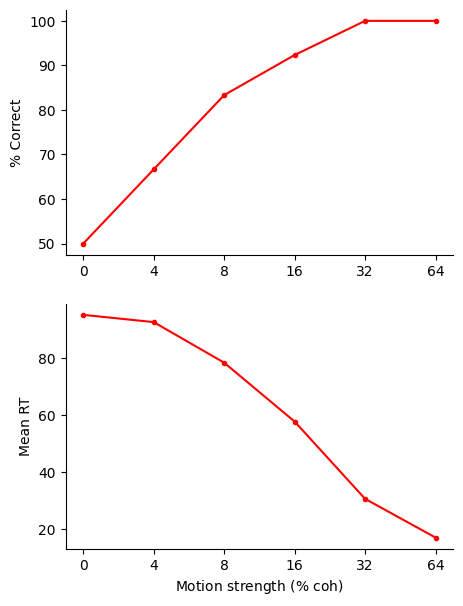

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(5,7))

axs[0].plot(p_correct, marker='.', color='r' )
axs[0].set_ylabel('% Correct')
axs[1].plot(jnp.mean(RTs_p, axis=0), marker='.', color='r')
axs[1].set_ylabel('Mean RT')
axs[1].set_xlabel('Motion strength ($\%$ coh)')
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ticks = np.arange(len(mu[val:]))  
    tick_labels = [f"{int(x * 100)}" for x in mu[val:]]  
    ax.set_xticks(ticks)  
    ax.set_xticklabels(tick_labels)  



In [42]:
def project(paths, proj_dims = 10):
    proj_matrix = random.normal(key, (proj_dims, 1))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                                        #(N',N)
    return jnp.einsum('dn,lknt->lkdt', proj_matrix, paths[:,:,jnp.newaxis,:])           #(trial, K, N=1, T)

def relu(x):
    return jnp.maximum(0, x)

def add_low_rank_noise(X, key1, key2, proj_dims = 3, sigma = 0.05 ):
    trials, K, N, T = X.shape    
    B = random.normal(key1, (N, proj_dims))
    B, _ = jnp.linalg.qr(B)

    epsilon_t = random.normal(key2, (trials, K, T, proj_dims)) * sigma  
    noise = jnp.einsum('lktd,nd->lknt', epsilon_t, B)             
    
    X += noise                                                   
    return X


neural_traces = relu(project(paths))
neural_traces = neural_traces * 10

# noise = random.normal(key, (X.shape)) / 1000
# X += noise
key = random.PRNGKey(42)
key, subkey = random.split(key)
neural_traces = add_low_rank_noise(neural_traces, key, subkey)        #(trials, K, N, T)

X = jnp.mean( neural_traces, axis=0 )
#X = neural_traces.squeeze()
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)               
A = A.reshape(N,-1)      

In [43]:
d = 2
c = 40
kernel_function = K_X_Y_squared_exponential

wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=300, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

Iteration 0, S: 5.361299991607666, S_ratio: 0.0097068902105093
Iteration 10, S: 49.40469741821289, S_ratio: 0.05375956371426582
Iteration 20, S: 217.17160034179688, S_ratio: 0.11693502962589264
Iteration 30, S: 528.8026733398438, S_ratio: 0.15851223468780518
Iteration 40, S: 984.5628051757812, S_ratio: 0.14525699615478516
Iteration 50, S: 1421.020751953125, S_ratio: 0.14849232137203217
Iteration 60, S: 2172.713623046875, S_ratio: 0.16591450572013855
Iteration 70, S: 2417.280029296875, S_ratio: 0.1637183278799057
Iteration 80, S: 2947.97314453125, S_ratio: 0.1819937527179718
Iteration 90, S: 2822.4931640625, S_ratio: 0.1794552057981491
Iteration 100, S: 2895.546630859375, S_ratio: 0.17945070564746857
Iteration 110, S: 3728.20556640625, S_ratio: 0.1702667772769928
Iteration 120, S: 3950.78955078125, S_ratio: 0.18808485567569733
Iteration 130, S: 3688.40234375, S_ratio: 0.16631290316581726
Iteration 140, S: 3444.468017578125, S_ratio: 0.1734052449464798
Iteration 150, S: 4218.3125, S_rati

Text(0.5, 1.0, 'kSCA; s = 0.29221877455711365')

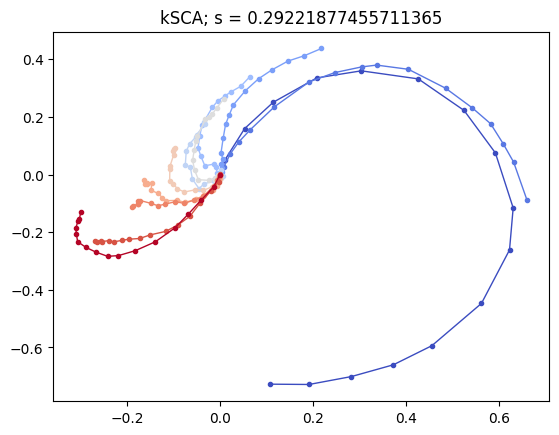

<Figure size 640x480 with 0 Axes>

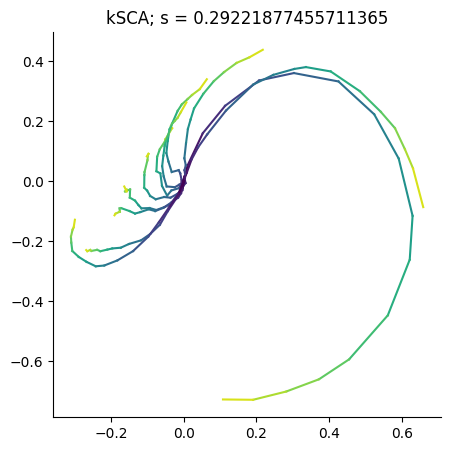

In [44]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u, _  = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

for i in range(Y.shape[0]):
    #Y = Y[:,:,:jnp.array(RTs).reshape(-1)[i]]
    Y = Y[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]

fig = plt.figure()
ax = fig.add_subplot(111) #projection='3d'
cmap = plt.get_cmap('coolwarm', K)
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    
    #z = Y[k, 2, :] 
    #color = cmap(k / K)
    #ax.plot(x, y, z, linestyle='-', marker='.', linewidth=1, color=color)
    color = cmap(k / (K - 1)) 
    ax.plot(x, y, linestyle='-', marker='.', linewidth=1, color=color)
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

plt.figure()
plot_2D(Y[:,:,:])
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

In [45]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()